# Human Activity Recognition
Human activity recognition, or HAR, is a challenging time series classification task.
<br><br>
It involves predicting the movement of a person based on sensor data and traditionally involves deep domain expertise and methods from signal processing to correctly engineer features from the raw data in order to fit a machine learning model.
<br><br>
Recently, deep learning methods such as convolutional neural networks have shown capable and even achieve state-of-the-art results by automatically learning features from the raw sensor data. In this notebook we will build a Convolution neural network using the TensorFlow library. Dataset used is the MotionSense Data posted on <a href="https://www.kaggle.com/malekzadeh/motionsense-dataset">Kaggle</a>

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

### Load Data
The dataset includes time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). It is collected with an iPhone 6s kept in the participant's front pocket.
<br><br>
The data is organized in multiple folders. Each folder contains 24 data files (one for each subject) for a particular acitivty. <br>
dws: Walking Downstairs
<br>
jog: Jogging
<br>
sit: Sitting
<br>
std: Standing 
<br>
ups: Walking Upstairs
<br>
wlk: Walking

In [236]:
print(os.listdir('motionsense-dataset'))

['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']


we will collate the data in single dataset

In [318]:
folders = glob('motionsense-dataset/*')
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_types = list(activity_codes.keys())

for j in folders:
    #print('j',j)
    csv = glob(j + '/*')
    for i in csv:
        df = pd.read_csv(i)
        df['activity'] = activity_codes[j[20:23]]
        df['sub_num'] = i[len(j)+5:-4]
        expnum = np.zeros(df.shape[0])
        df_all_list.append(df)
df_all = pd.concat(df_all_list,axis=0)
df_all = df_all.drop('Unnamed: 0',axis=1)
print(df_all.shape)
print(df_all.columns)


(1412865, 14)
Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z', 'activity', 'sub_num'],
      dtype='object')


### Visualization
Let's visualize one timeseries per acitivty

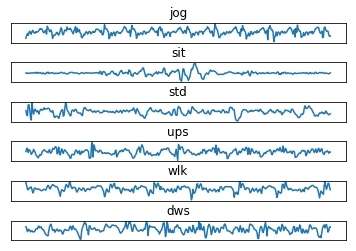

In [327]:
for act in activity_types:
    plt.subplot('61'+str(activity_codes[act]))
    plt.subplots_adjust(hspace=1.0)
    df = df_all[(df_all['sub_num']=='1') & (df_all['activity']==activity_codes[act])]
    plt.title(act)
    plt.plot(df['userAcceleration.z'][:400])
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels

### Data Preprocessing 
For convolution neural network the input data needs to be in a particular format. We will organize data windows of 400 datapoints with 12 channels (one channel per reading).

In [328]:
segment_size = 400
data_all_x_list = []
data_all_y_list = []
for j in folders:
    #print('j',j)
    csv = glob(j + '/*')
    for i in csv:
        df = pd.read_csv(i)
        df = df.drop('Unnamed: 0',axis=1)
        win_count = int(df.shape[0]/segment_size)
        data_x = np.zeros((win_count,segment_size,df.shape[1]))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = c*segment_size
            end_idx = start_idx + segment_size
            data_x[c,:,:] = df[start_idx:end_idx].values
            data_y[:] = activity_codes[j[20:23]]
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(3359, 400, 12)
(3359,)


### Convolution Neural Network
Following the architecture we will be training for this problem.
<br>
<img src="network1.jpg" alt="network">
<br>
The activation used is <b> relu</b>
<br> the probabilities for each class is calculated applying <b> SoftMax</b> on last layer (Logit)

In [1]:
def cnn_model_fn(features,labels,mode):
    conv1 = tf.layers.conv1d(inputs=features,
                             filters=32,
                             kernel_size=5,
                             padding='same',
                             data_format='channels_last',
                             activation=tf.nn.relu)
    print('conv1.shape',conv1.shape)
    pool1 = tf.layers.max_pooling1d(inputs=conv1,pool_size=2,strides=2)
    print('pool1.shape',pool1.shape)
    
    conv2 = tf.layers.conv1d(inputs=pool1,
                             filters=64,
                             kernel_size=5,
                             padding='same',
                             data_format='channels_last',
                             activation=tf.nn.relu)
    print('conv2.shape',conv2.shape)
    pool2 = tf.layers.max_pooling1d(inputs=conv2,pool_size=2,strides=2)
    print('pool2.shape',pool2.shape)
    
    pool2_flat = tf.reshape(pool2,[-1,100*64])  
    dense1 = tf.layers.dense(inputs=pool2_flat,units=500,activation=tf.nn.relu)
    
    dropput = tf.layers.dropout(inputs=dense1,rate=0.1,training=(mode==tf.estimator.ModeKeys.TRAIN))
    
    dense2 =  tf.layers.dense(inputs=dropput,units=100,activation=tf.nn.relu)
    
    logits = tf.layers.dense(inputs=dense2,units=6)
    
    predictions = { 'classes':tf.arg_max(logits,dimension=1),
                 'probabilites': tf.nn.softmax(logits,name = 'softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)
    
    eval_metric_op = {'accuracy': tf.metrics.accuracy(labels=labels,predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_metric_op)

In [310]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.1)

In [311]:
har_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir='/tmp/har_classifer_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/har_classifer_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FC12FAC320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [312]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

In [316]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = train_x,
    y = train_y,
    batch_size=10,
    num_epochs=None,
    shuffle=True)


har_classifier.train(
    input_fn=train_input_fn,
    steps=20000)
    #hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
conv1.shape (10, 400, 32)
pool1.shape (10, 200, 32)
conv2.shape (10, 200, 64)
pool2.shape (10, 100, 64)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/har_classifer_model\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 200 into /tmp/har_classifer_model\model.ckpt.
INFO:tensorflow:loss = 1.2836862802505493, step = 201
INFO:tensorflow:global_step/sec: 17.0172
INFO:tensorflow:loss = 1.1545366048812866, step = 301 (5.881 sec)
INFO:tensorflow:global_step/sec: 17.3632
INFO:tensorflow:loss = 0.655805230140686, step = 401 (5.760 sec)
INFO:tensorflow:global_step/sec: 17.405
INFO:tensorflow:loss = 0.9856066703796387, step = 501 (5.745 sec)
INFO:tensorflow:global_step/sec: 18.7969
INFO:tensorflow:loss = 0.8814412951469421, step = 601 (5.319 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.029449744150042534, step = 7301 (5.669 sec)
INFO:tensorflow:global_step/sec: 17.1385
INFO:tensorflow:loss = 0.002629772759974003, step = 7401 (5.833 sec)
INFO:tensorflow:global_step/sec: 17.3418
INFO:tensorflow:loss = 0.0659339427947998, step = 7501 (5.763 sec)
INFO:tensorflow:global_step/sec: 17.0469
INFO:tensorflow:loss = 0.020894208922982216, step = 7601 (5.868 sec)
INFO:tensorflow:global_step/sec: 18.5798
INFO:tensorflow:loss = 0.013088327832520008, step = 7701 (5.383 sec)
INFO:tensorflow:global_step/sec: 17.0531
INFO:tensorflow:loss = 0.17797182500362396, step = 7801 (5.865 sec)
INFO:tensorflow:global_step/sec: 17.1217
INFO:tensorflow:loss = 0.01972433365881443, step = 7901 (5.841 sec)
INFO:tensorflow:global_step/sec: 17.2773
INFO:tensorflow:loss = 0.03711467236280441, step = 8001 (5.785 sec)
INFO:tensorflow:global_step/sec: 18.0707
INFO:tensorflow:loss = 0.04862092062830925, step = 8101 (5.534 sec)
INFO:tensorflow:global_step/sec: 17.5462
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 17.0442
INFO:tensorflow:loss = 0.07317807525396347, step = 14701 (5.865 sec)
INFO:tensorflow:global_step/sec: 17.1383
INFO:tensorflow:loss = 0.031148195266723633, step = 14801 (5.835 sec)
INFO:tensorflow:global_step/sec: 16.8032
INFO:tensorflow:loss = 0.0020857814233750105, step = 14901 (5.954 sec)
INFO:tensorflow:global_step/sec: 17.3074
INFO:tensorflow:loss = 0.019898030906915665, step = 15001 (5.776 sec)
INFO:tensorflow:global_step/sec: 20.3024
INFO:tensorflow:loss = 0.061551082879304886, step = 15101 (4.926 sec)
INFO:tensorflow:global_step/sec: 18.0803
INFO:tensorflow:loss = 0.0043495893478393555, step = 15201 (5.532 sec)
INFO:tensorflow:global_step/sec: 17.3495
INFO:tensorflow:loss = 0.005925298202782869, step = 15301 (5.762 sec)
INFO:tensorflow:global_step/sec: 18.7016
INFO:tensorflow:loss = 0.02682671882212162, step = 15401 (5.349 sec)
INFO:tensorflow:global_step/sec: 21.1643
INFO:tensorflow:loss = 0.002690159482881427, step = 15501 (4.725 sec)
I

In [317]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = test_x,
    y = test_y,
    num_epochs=1,
    shuffle=False)

eval_results = har_classifier.evaluate(input_fn=test_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
conv1.shape (?, 400, 32)
pool1.shape (?, 200, 32)
conv2.shape (?, 200, 64)
pool2.shape (?, 100, 64)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-17-17:17:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/har_classifer_model\model.ckpt-20200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-17-17:17:21
INFO:tensorflow:Saving dict for global step 20200: accuracy = 0.98511904, global_step = 20200, loss = 0.05000393
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20200: /tmp/har_classifer_model\model.ckpt-20200
{'accuracy': 0.98511904, 'loss': 0.05000393, 'global_step': 20200}


### Results
The accuracy achieved on Test set is <b> more then 98% </b>